<a href="https://colab.research.google.com/github/kurtsenol/machine-learning/blob/master/TopicModeling/LDA_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import pandas as pd
import pickle

In [ ]:
df = pd.read_pickle("drive/My Drive/Topic_Modeling/topic_df.pkl")

In [ ]:
df

,Title,Journal,Year,Abstract
0,TWO-DIRECTIONAL CONVERGENCE OF PLATFORM AND PI...,JOURNAL OF SERVICE MANAGEMENT,2020,PURPOSE THIS ARTICLE EXAMINES THE NEW PHENOMEN...
1,EMPLOYEE WELLNESS ON THE FRONTLINE: AN INTERAC...,JOURNAL OF SERVICE MANAGEMENT,2020,PURPOSE EMPLOYEE WELLNESS IS VITAL TO CREATING...
2,DEMOGRAPHIC AND ATTITUDINAL ANTECEDENTS OF CON...,JOURNAL OF SERVICE MANAGEMENT,2020,PURPOSE TO INVESTIGATE IF ONLINE TV CONTENT PL...
3,MORE THAN A FEELING? TOWARD A THEORY OF CUSTOM...,JOURNAL OF SERVICE MANAGEMENT,2020,PURPOSE RESPONDING TO AN INCREASING CALL FOR A...
4,ACCOUNTABLE ALGORITHMS? THE ETHICAL IMPLICATIO...,JOURNAL OF SERVICE MANAGEMENT,2020,PURPOSE THE PURPOSE OF THIS STUDY IS TO IDENTI...
...,...,...,...,...
11380,TOURIST INFORMATION SEARCH AND DESTINATION CHO...,TOURISM MANAGEMENT PERSPECTIVES,2012,THIS STUDY PROVIDES EMPIRICAL EVIDENCE OF SELF...
11381,TOURISTS' OPINIONS AND THEIR SELECTION OF TOUR...,TOURISM MANAGEMENT PERSPECTIVES,2012,IMAGE IS AN IMPORTANT COMPONENT OF TOURISM DES...
11382,TOWARDS A COMMON AGENDA FOR THE DEVELOPMENT OF...,TOURISM MANAGEMENT PERSPECTIVES,2012,BUILDING ON CASE STUDIES OF FOUR EUROPEAN REGI...
11383,TOWARDS TOURISM INNOVATION: A CRITICAL REVIEW ...,TOURISM MANAGEMENT PERSPECTIVES,2012,UNDERSTANDING AND MANAGING THE RURAL TOURISM E...


In [ ]:
papers = list(df.Abstract.values)

In [ ]:
len(papers)

11385

In [ ]:
print(papers[0][:1000])

PURPOSE THIS ARTICLE EXAMINES THE NEW PHENOMENON OF THE CONVERGENCE OF PLATFORM AND PIPELINE BUSINESS MODELS. IT EXAMINES THE POTENTIAL SYNERGIES AND CHALLENGES FOR PLATFORMS TO ADD PIPELINE COMPONENTS AND VICE VERSA FOR PIPELINE BUSINESSES. DESIGN/METHODOLOGY/APPROACH THIS PAPER USES A CONCEPTUAL APPROACH THAT SYNTHESIZES AND INTEGRATES THE LITERATURE FROM SERVICE, HOSPITALITY, AND STRATEGY, AND SUPPLEMENTS THEM WITH TWO ILLUSTRATIVE MINI-CASE STUDIES. FINDINGS WHILE THE EXTANT LITERATURE TYPICALLY FOCUSES ON THE DICHOTOMY BETWEEN INCUMBENT PIPELINE BUSINESSES THAT CREATE VALUE BY CONTROLLING A LINEAR SERIES OF ACTIVITIES AND NETWORK EFFECTS-DRIVEN PLATFORMS, WE DIFFERENTIATE BETWEEN TWO TYPES OF PLATFORM BUSINESS MODELS (I.E. PLATFORMS WITH ASSET CONTROL AND PLATFORMS WITH PEER-PROVIDED ASSETS). FURTHER, WE IDENTIFY THREE COMMON PATHWAYS OF CONVERGENCE; THAT IS, PIPELINES MOVING TOWARDS (1) PLATFORMS WITH ASSET CONTROL AND (2) THOSE WITH PEER-PROVIDED ASSETS, AND (3) PLATFORMS WITH P

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
!pip install pyLDAvis

     |████████████████████████████████| 1.6MB 2.8MB/s 
     |████████████████████████████████| 552kB 15.4MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97711 sha256=27e1fdd3d2e264bf1ede4c433386d435654d56ba2a0850ab550330fa7e76bdb5
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
  Created wheel for funcy: filename=funcy-1.14-py2.py3-none-any.whl size=32042 sha256=cfcdb4d6fb9f774f36a2dc0fde138c22866f107f560e8bbbb776adb486a327d0
  Stored in directory: /root/.cache/pip/wheels/20/5a/d8/1d875df03deae6f178dfdf70238cca33f948ef8a6f5209f2eb
Successfully built pyLDAvis funcy


In [ ]:
!python -m spacy download en_core_web_md

     |████████████████████████████████| 96.4MB 1.1MB/s 
  Created wheel for en-core-web-md: filename=en_core_web_md-2.2.5-cp36-none-any.whl size=98051305 sha256=62076fe994a29dabeecbf2853a332c1442d630bfbb92d9f9676d27f0fed48beb
  Stored in directory: /tmp/pip-ephem-wheel-cache-4ddmrawv/wheels/df/94/ad/f5cf59224cea6b5686ac4fd1ad19c8a07bc026e13c36502d81
Successfully built en-core-web-md
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [ ]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [ ]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

### Tokenize Sentences and Clean
Removing the emails, new line characters, single quotes and finally split the sentence into a list of words using gensim’s simple_preprocess(). Setting the deacc=True option removes punctuations.

In [ ]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = df.Abstract.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])

[['purpose', 'this', 'article', 'examines', 'the', 'new', 'phenomenon', 'of', 'the', 'convergence', 'of', 'platform', 'and', 'pipeline', 'business', 'models', 'it', 'examines', 'the', 'potential', 'synergies', 'and', 'challenges', 'for', 'platforms', 'to', 'add', 'pipeline', 'components', 'and', 'vice', 'versa', 'for', 'pipeline', 'businesses', 'design', 'methodology', 'approach', 'this', 'paper', 'uses', 'conceptual', 'approach', 'that', 'synthesizes', 'and', 'integrates', 'the', 'literature', 'from', 'service', 'hospitality', 'and', 'strategy', 'and', 'supplements', 'them', 'with', 'two', 'illustrative', 'mini', 'case', 'studies', 'findings', 'while', 'the', 'extant', 'literature', 'typically', 'focuses', 'on', 'the', 'dichotomy', 'between', 'incumbent', 'pipeline', 'businesses', 'that', 'create', 'value', 'by', 'controlling', 'linear', 'series', 'of', 'activities', 'and', 'network', 'effects', 'driven', 'platforms', 'we', 'differentiate', 'between', 'two', 'types', 'of', 'platform',

### Build the Bigram, Trigram Models and Lemmatize
Let’s form the bigram and trigrams using the Phrases model. This is passed to Phraser() for efficiency in speed of execution.

Next, lemmatize each word to its root form, keeping only nouns, adjectives, verbs and adverbs.

We keep only these POS tags because they are the ones contributing the most to the meaning of the sentences. Here, I use spacy for lemmatization.

In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [ ]:
data_ready = process_words(data_words)  # processed Text Data!

### Build the Topic Model
To build the LDA topic model using LdaModel(), you need the corpus and the dictionary. Let’s create them first and then build the model. The trained topics (keywords and weights) are printed below as well.

If you examine the topic key words, they are nicely segregate and collectively represent the topics we initially chose: Christianity, Hockey, MidEast and Motorcycles. Nice!

In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=1000,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=500,
                                           per_word_topics=True)

pprint(lda_model.print_topics())

[(0,
  '0.023*"study" + 0.021*"research" + 0.014*"use" + 0.014*"hospitality" + '
  '0.011*"performance" + 0.011*"service" + 0.011*"paper" + 0.011*"management" '
  '+ 0.010*"industry" + 0.010*"firm"'),
 (1,
  '0.019*"tourism" + 0.016*"model" + 0.016*"result" + 0.016*"use" + '
  '0.015*"effect" + 0.014*"impact" + 0.013*"risk" + 0.013*"study" + '
  '0.011*"time" + 0.010*"economic"'),
 (2,
  '0.031*"tourist" + 0.030*"experience" + 0.024*"tourism" + 0.018*"travel" + '
  '0.017*"study" + 0.009*"research" + 0.008*"cultural" + 0.007*"motivation" + '
  '0.007*"explore" + 0.005*"chinese"'),
 (3,
  '0.045*"restaurant" + 0.020*"scale" + 0.014*"student" + 0.011*"program" + '
  '0.011*"airline" + 0.011*"medical" + 0.010*"develop" + 0.009*"service" + '
  '0.009*"item" + 0.009*"study"'),
 (4,
  '0.063*"tourism" + 0.016*"development" + 0.012*"paper" + 0.009*"sustainable" '
  '+ 0.009*"industry" + 0.008*"stakeholder" + 0.008*"policy" + '
  '0.008*"environmental" + 0.008*"sustainability" + 0.007*"change"

In [ ]:
cv_coherence_model_lda = gensim.models.CoherenceModel( model=lda_model, corpus=corpus, texts=data_ready,
                                                      dictionary=id2word, coherence='c_v')

avg_coherence_cv = cv_coherence_model_lda.get_coherence()

In [ ]:
print('Avg. Coherence Score (Cv):', avg_coherence_cv)

Avg. Coherence Score (Cv): 0.3970561074846165


### What is the Dominant topic and its percentage contribution in each document
In LDA models, each document is composed of multiple topics. But, typically only one of the topics is dominant. The below code extracts this dominant topic for each sentence and shows the weight of the topic and the keywords in a nicely formatted output.

This way, you will know which document belongs predominantly to which topic.

In [ ]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)




In [ ]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)


In [ ]:

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.5050,"study, research, use, hospitality, performance...","[purpose, article, examine, new, convergence, ..."
1,1,9.0,0.4381,"customer, study, service, satisfaction, employ...","[purpose, employee, wellness, vital, create, h..."
2,2,9.0,0.4344,"customer, study, service, satisfaction, employ...","[purpose, investigate, online, tv, content, pl..."
3,3,9.0,0.3881,"customer, study, service, satisfaction, employ...","[purpose, respond, increase, call, comprehensi..."
4,4,0.0,0.7168,"study, research, use, hospitality, performance...","[purpose, purpose, study, explain, ethical, im..."
5,5,9.0,0.4333,"customer, study, service, satisfaction, employ...","[purpose, social, medium, use, become, pervasi..."
6,6,9.0,0.5394,"customer, study, service, satisfaction, employ...","[purpose, purpose, paper, consider, consumer, ..."
7,7,9.0,0.6207,"customer, study, service, satisfaction, employ...","[purpose, study, aim, investigate, bystander, ..."
8,8,0.0,0.6129,"study, research, use, hospitality, performance...","[purpose, paper, consider, question, would, ha..."
9,9,9.0,0.6485,"customer, study, service, satisfaction, employ...","[purpose, brand, increasingly, consider, use, ..."


In [ ]:
df_dominant_topic.Dominant_Topic.unique()

array([0., 9., 2., 4., 3., 1., 7., 6., 8., 5.])

### The most representative sentence for each topic
Sometimes you want to get samples of sentences that most represent a given topic. This code gets the most exemplar sentence for each topic.

In [ ]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9924,"study, research, use, hospitality, performance, service, paper, management, industry, firm","[purpose, purpose, paper, analyze, history, future, service, operation, goal, identify, key, the..."
1,1.0,0.9907,"tourism, model, result, use, effect, impact, risk, study, time, economic","[paper, use, relatively, new, heterogeneous, panel, cointegration, method, examine, relationship..."
2,2.0,0.9864,"tourist, experience, tourism, travel, study, research, cultural, motivation, explore, chinese","[qualitative, study, explore, travel, motivation, experience, asian, datum, collect, focus, trav..."
3,3.0,0.5115,"restaurant, scale, student, program, airline, medical, develop, service, item, study","[unruly, passenger, behavior, upbs, challenge, service, provision, enterprise, notably, airline,..."
4,4.0,0.9799,"tourism, development, paper, sustainable, industry, stakeholder, policy, environmental, sustaina...","[examine, collaboration, institutional, level, tourism, sector, central, region, research, begin..."
5,5.0,0.8806,"destination, image, food, tourist, event, visitor, study, brand, marketing, result","[food, image, begin, influence, tourist, behaviour, understand, food, image, important, study, e..."
6,6.0,0.6295,"online, information, use, medium, social, review, travel, website, consumer, wine","[grow, ownership, multiple, technology, device, contribution, mobile, travel, booking, overall, ..."
7,7.0,0.8451,"tourism, community, local, resident, rural, development, volunteer, impact, benefit, visitor","[study, aim, assess, support, community, resident, sustainable, tourism, development, use, laten..."
8,8.0,0.7305,"hotel, guest, price, segment, attribute, accommodation, market, difference, high, factor","[objective, food, relate, lifestyle, segment, mature, market, identify, investigate, difference,..."
9,9.0,0.9889,"customer, study, service, satisfaction, employee, relationship, effect, result, influence, finding","[draw, role, identity, current, study, present, model, use, supervisor, workaholism, perception,..."


### Frequency Distribution of Word Counts in Documents
When working with a large number of documents, you want to know how big the documents are as a whole and by topic. Let’s plot the document word counts distribution.

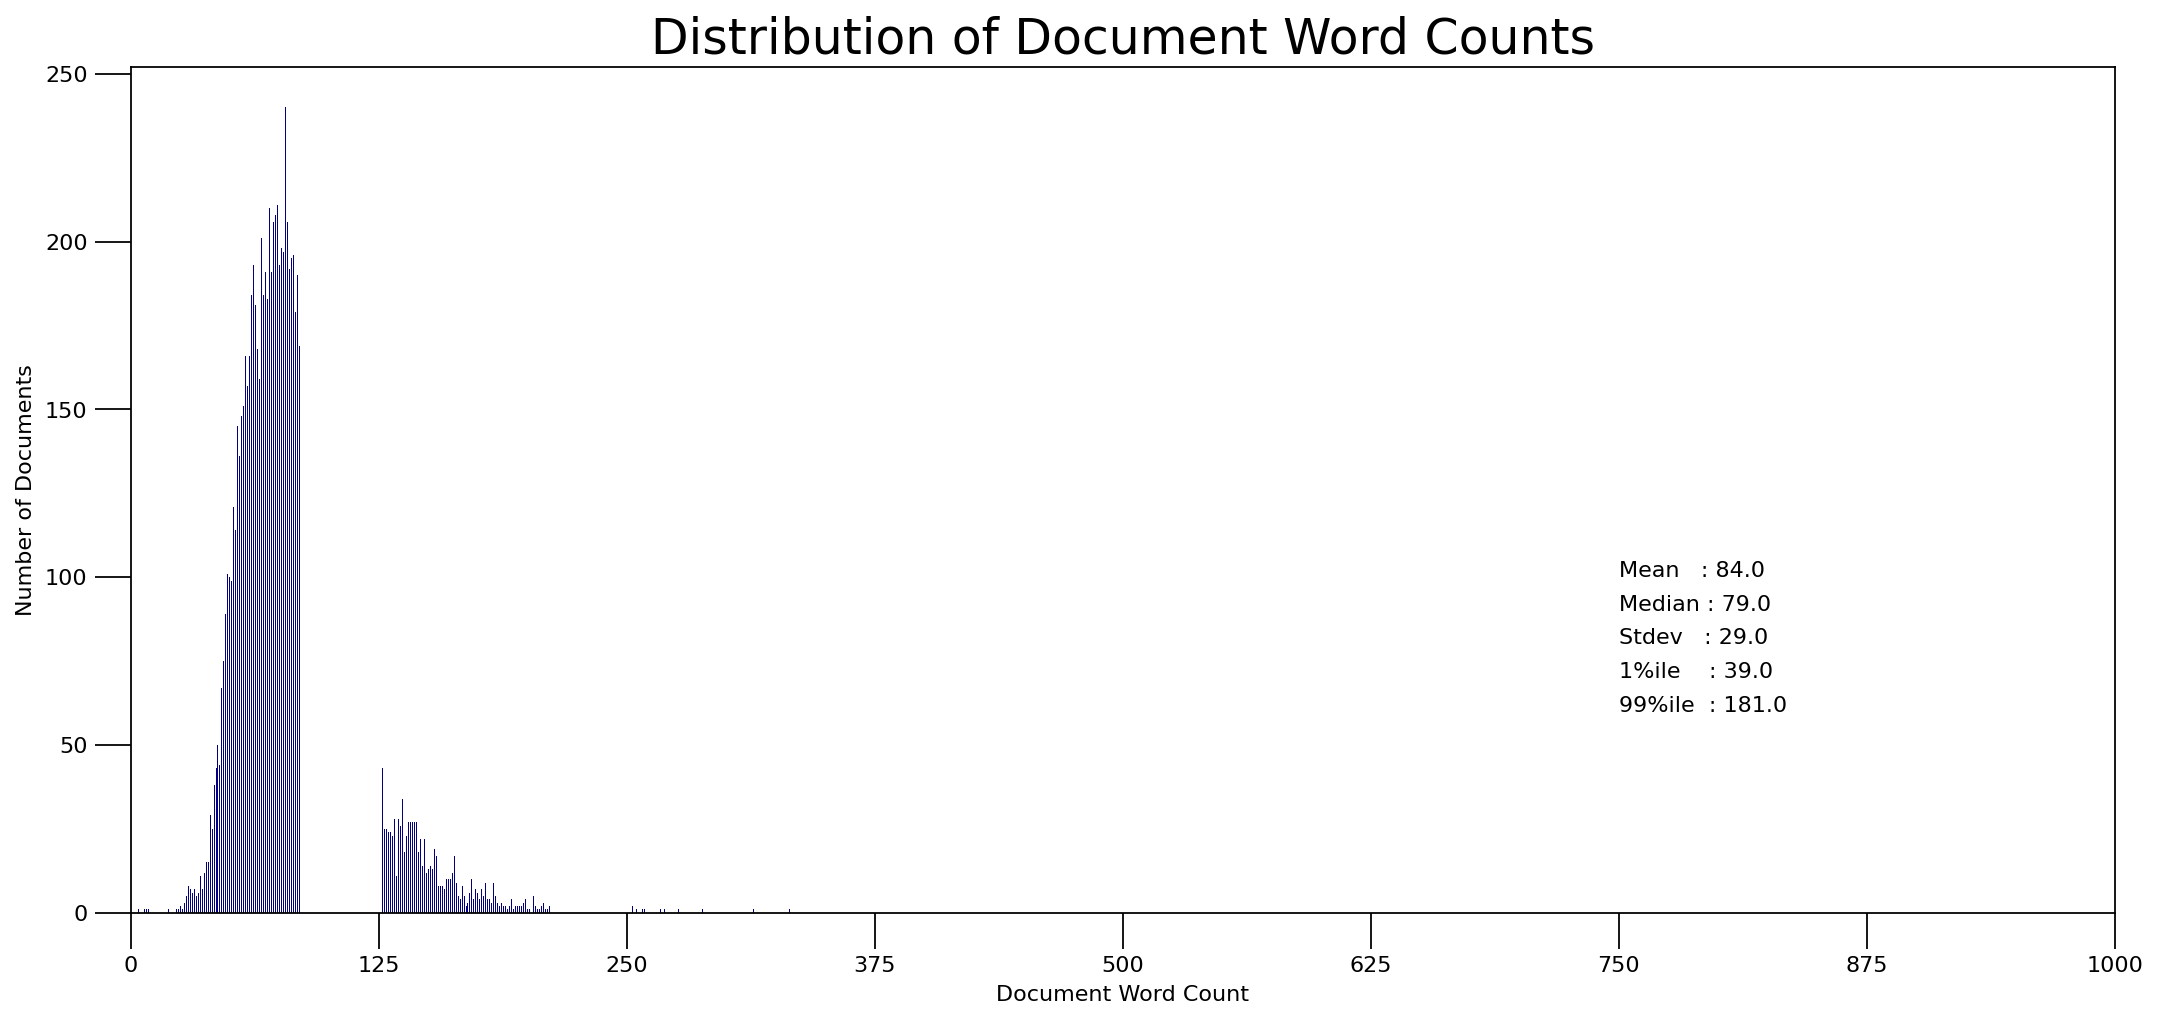

In [ ]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


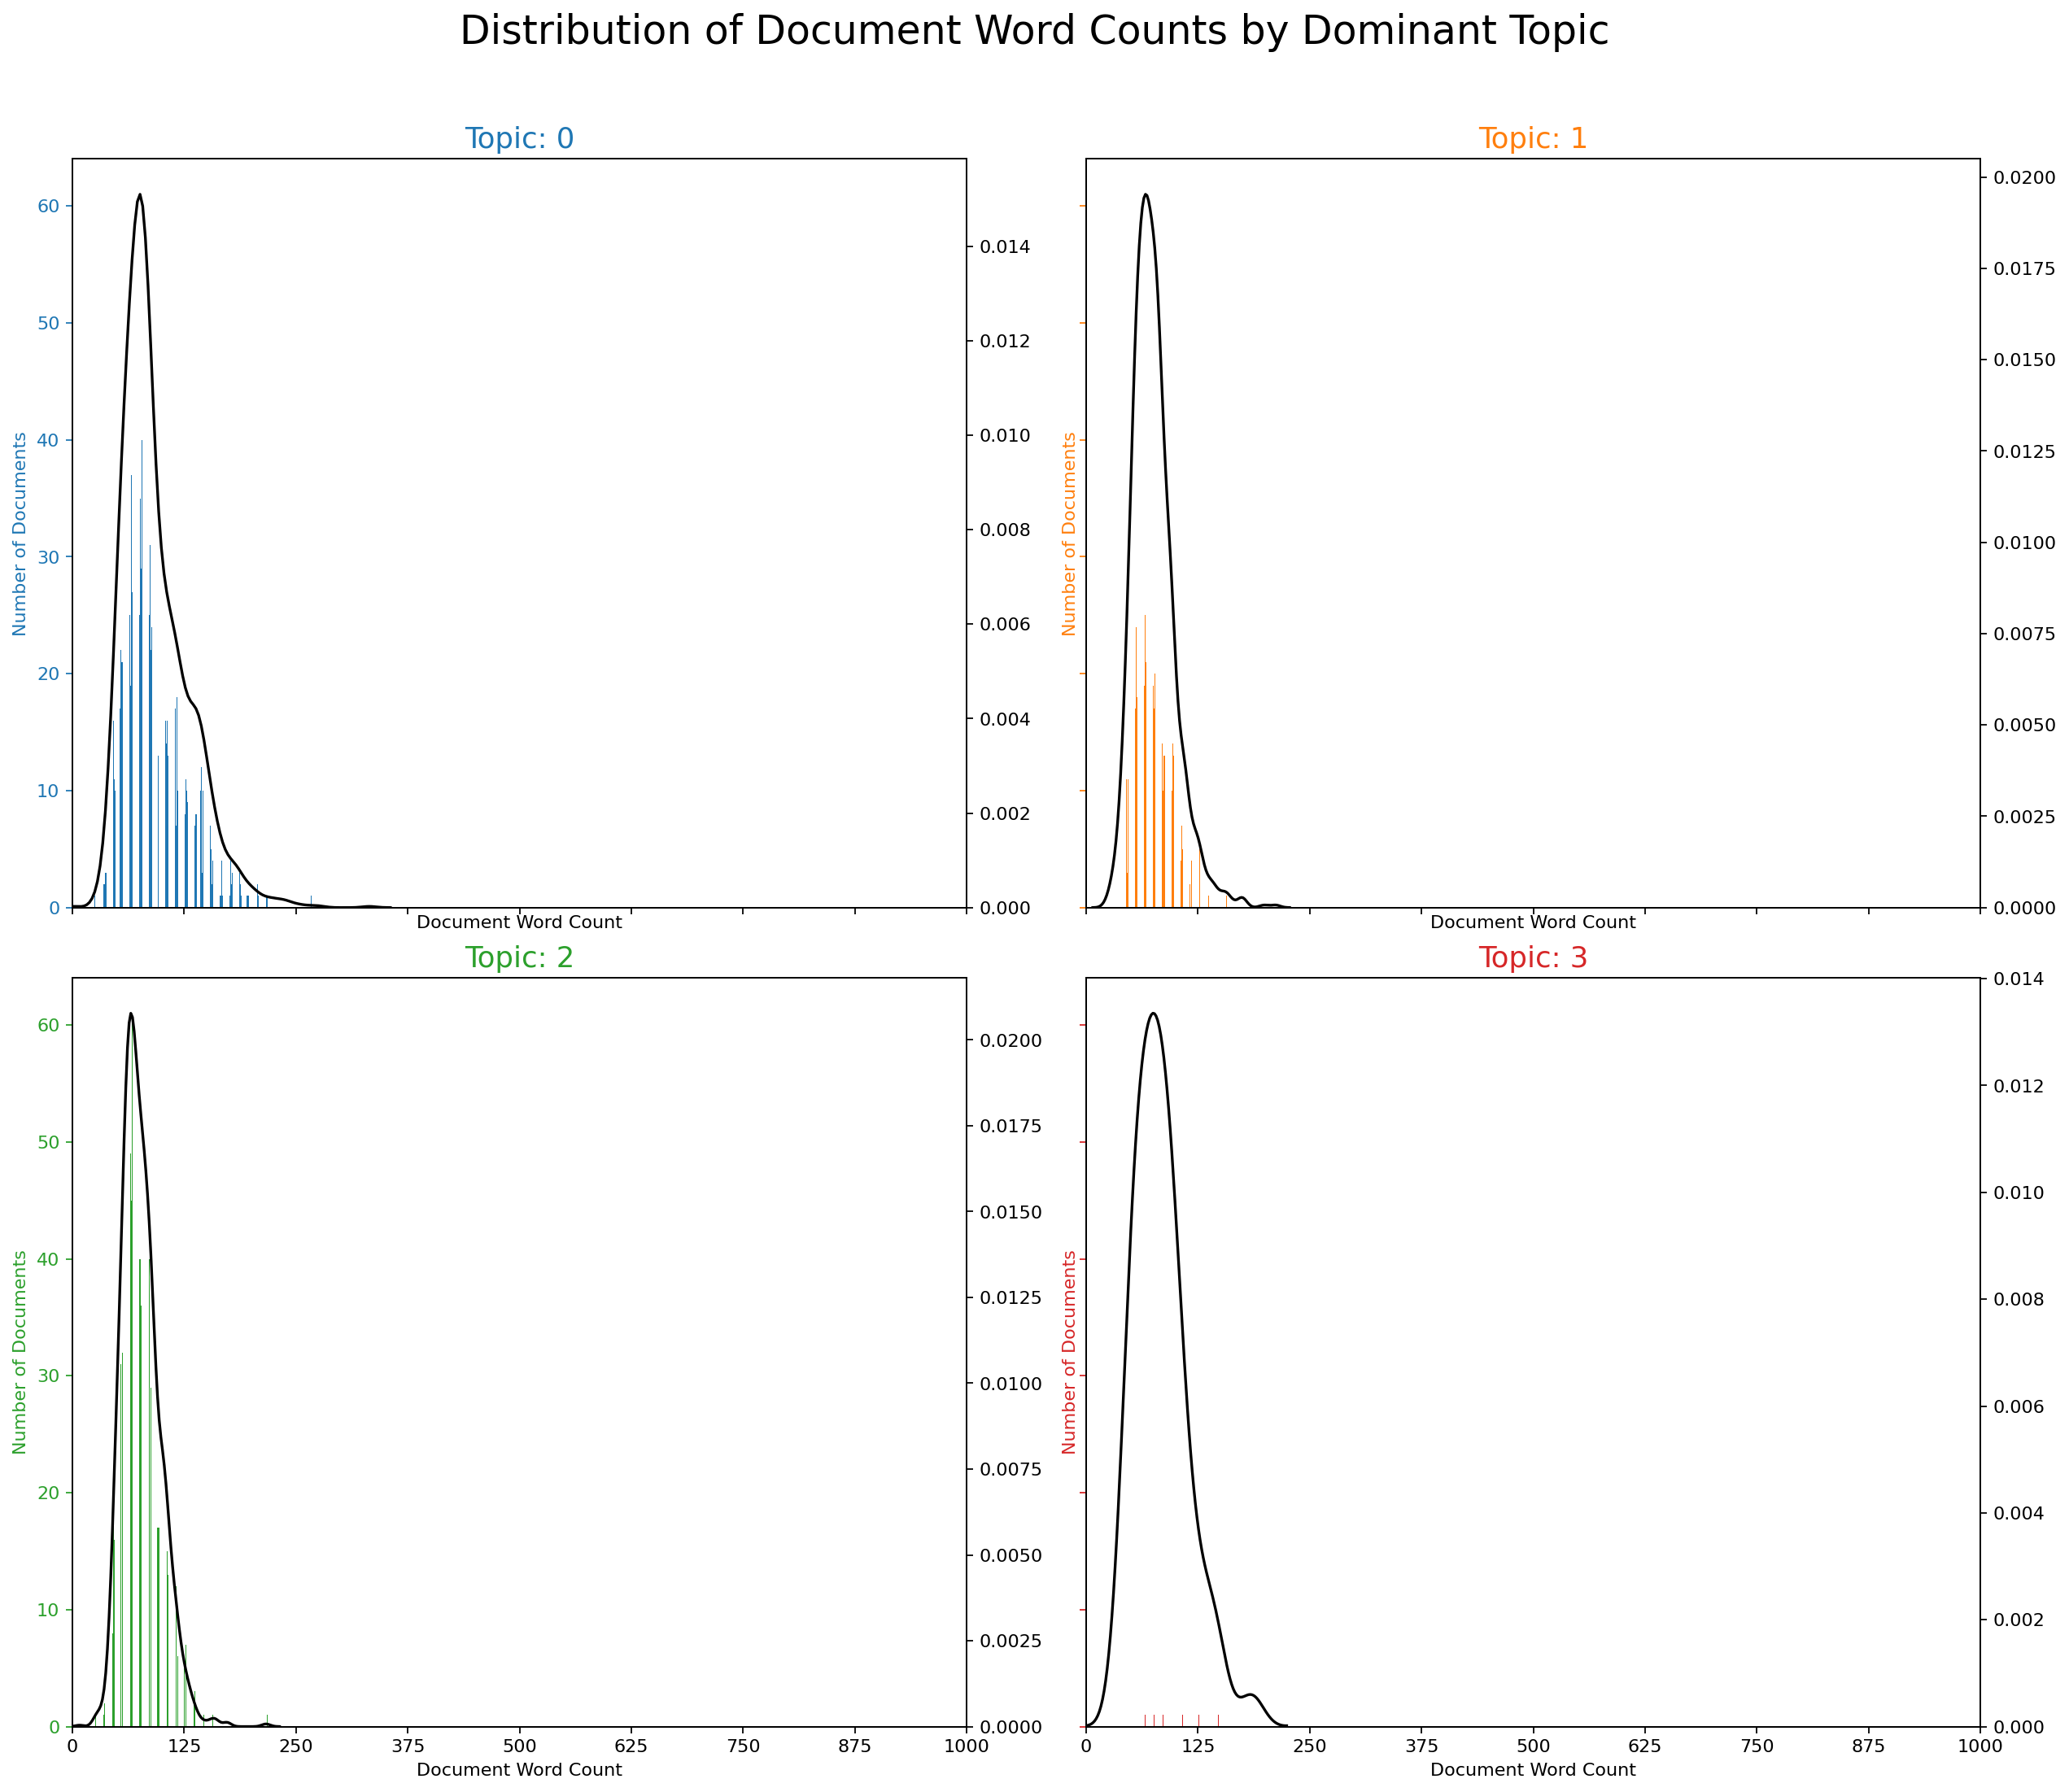

In [ ]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

### Word Clouds of Top N Keywords in Each Topic
Though you’ve already seen what are the topic keywords in each topic, a word cloud with the size of the words proportional to the weight is a pleasant sight. The coloring of the topics I’ve taken here is followed in the subsequent plots as well.

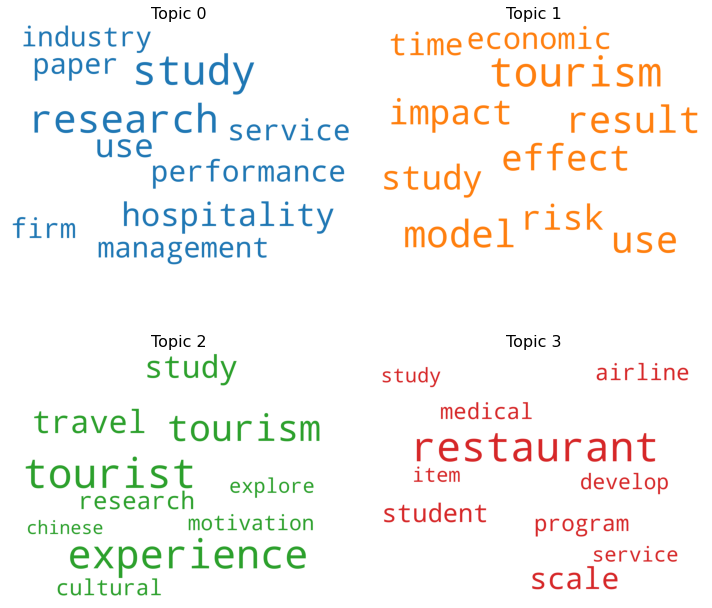

In [ ]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

### Word Counts of Topic Keywords
When it comes to the keywords in the topics, the importance (weights) of the keywords matters. Along with that, how frequently the words have appeared in the documents is also interesting to look.

Let’s plot the word counts and the weights of each keyword in the same chart.

You want to keep an eye out on the words that occur in multiple topics and the ones whose relative frequency is more than the weight. Often such words turn out to be less important. The chart I’ve drawn below is a result of adding several such words to the stop words list in the beginning and re-running the training process.

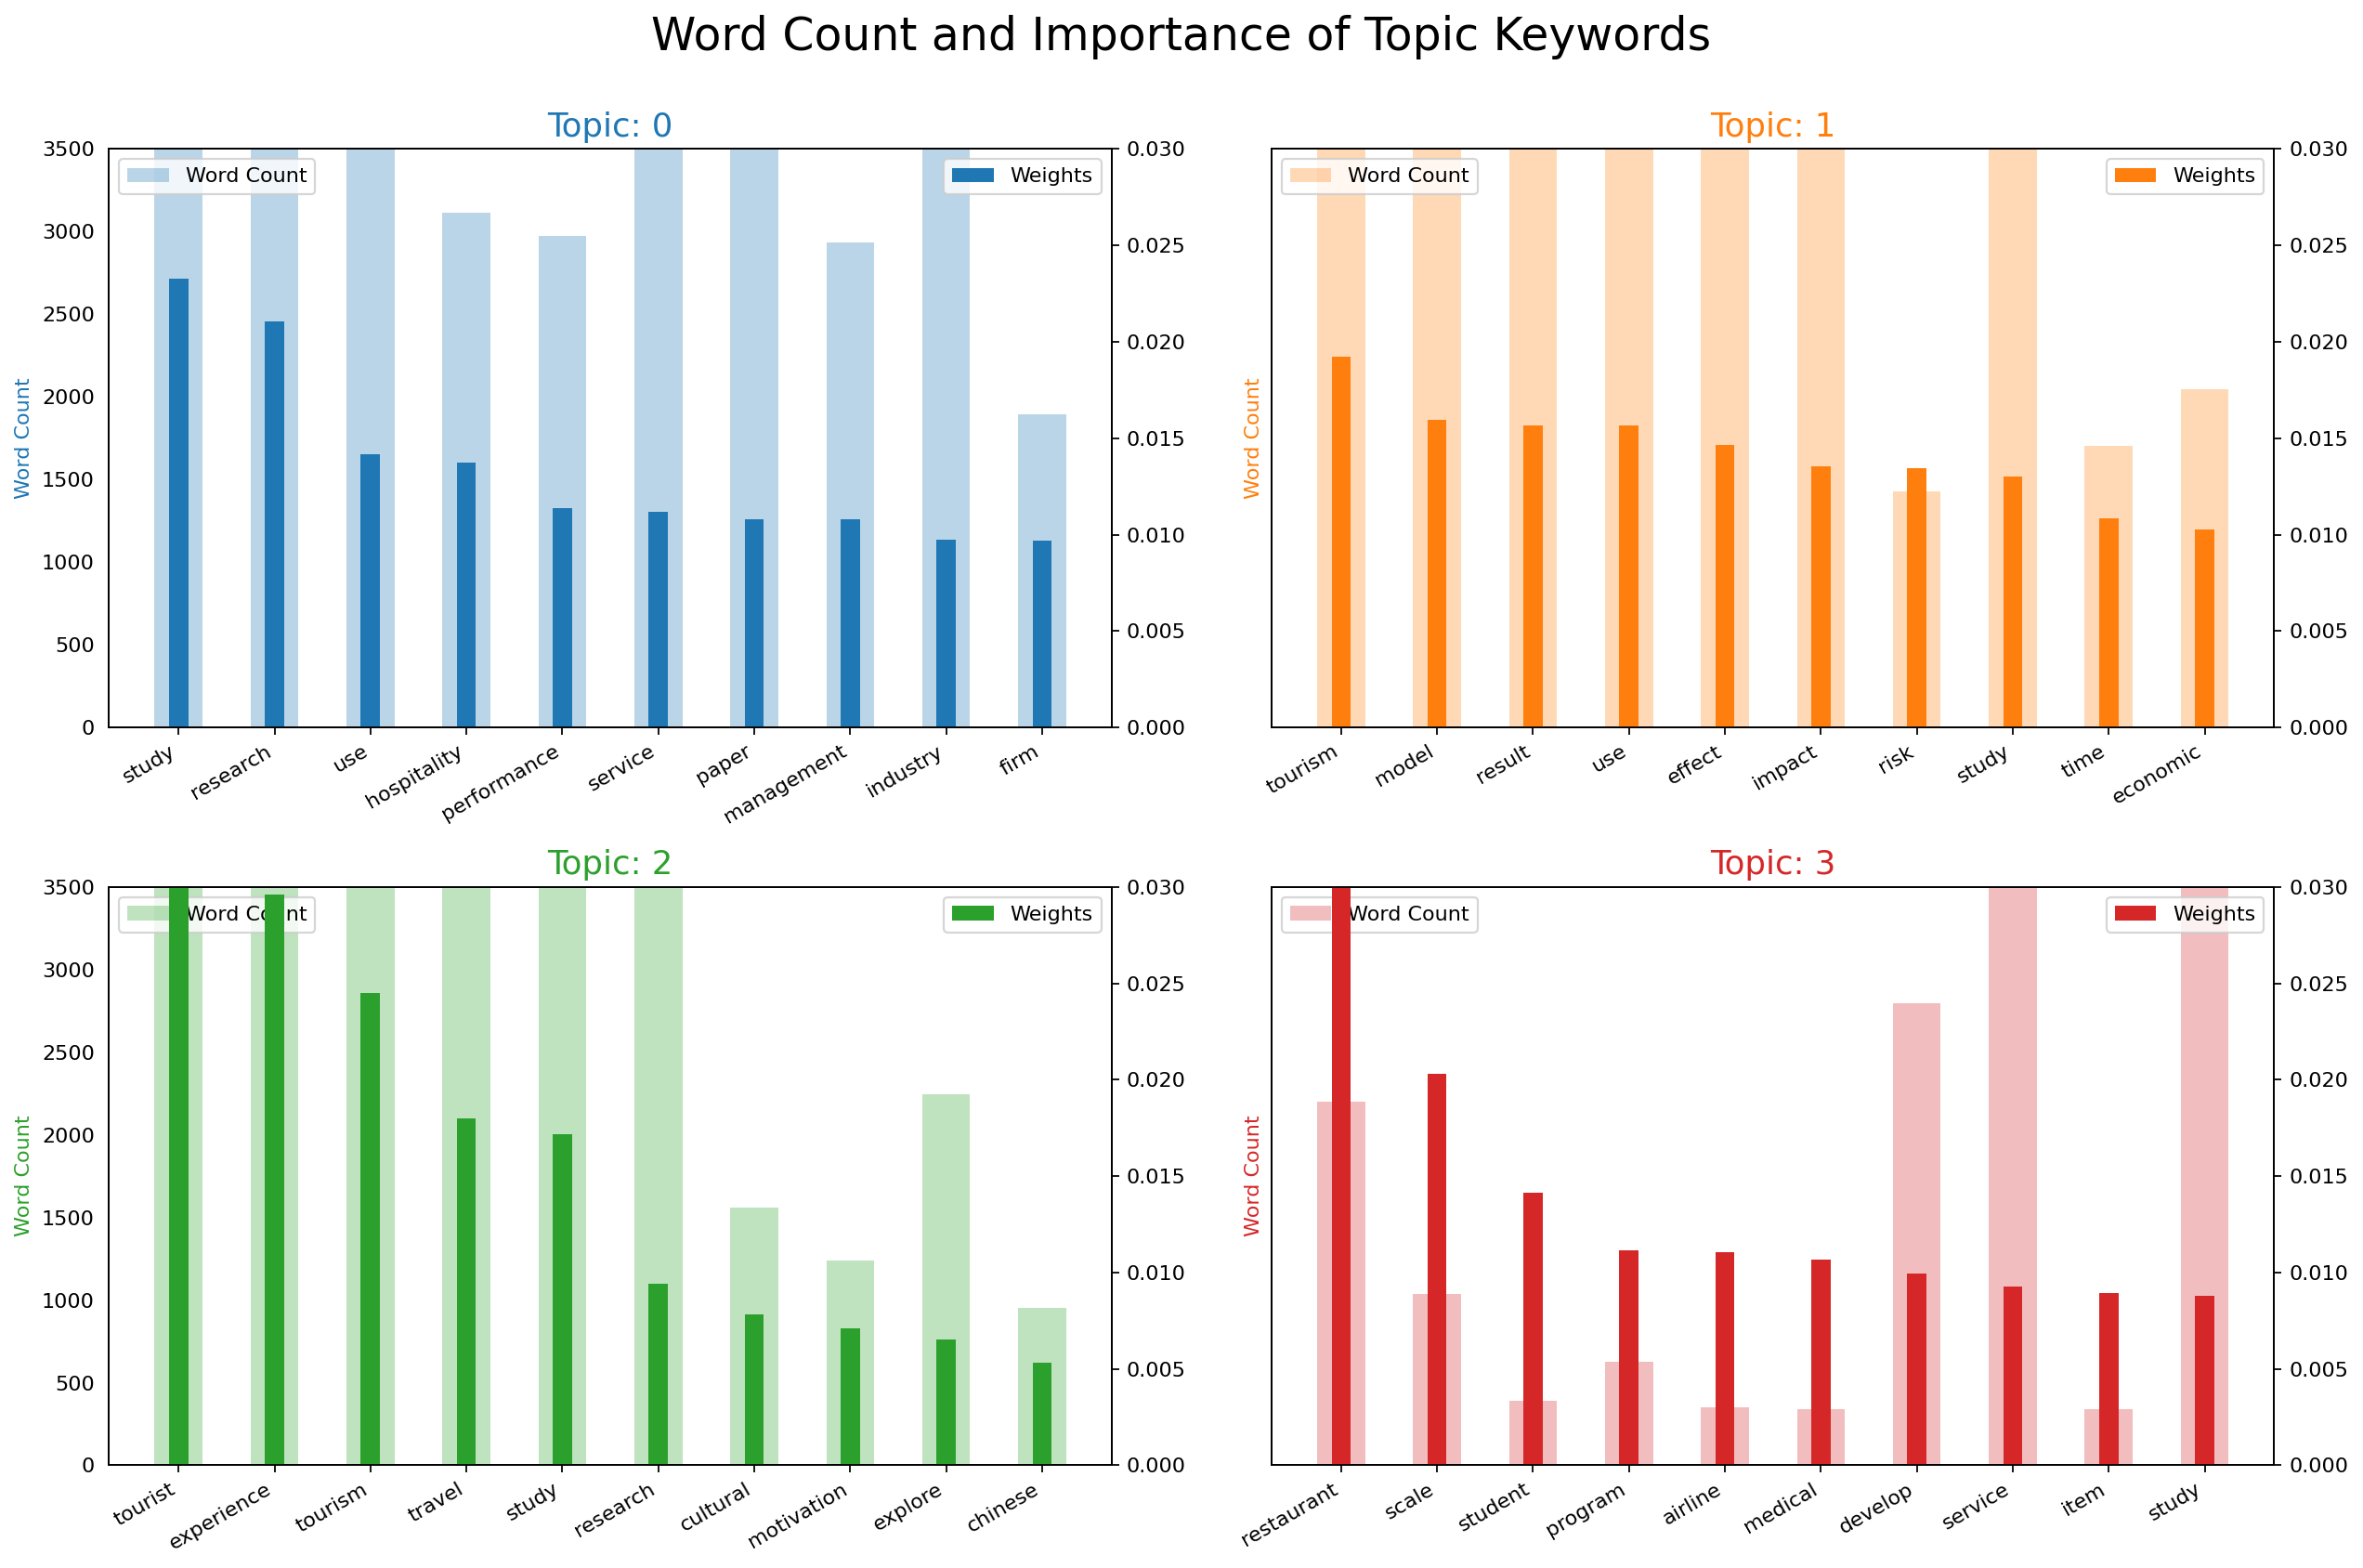

In [ ]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

### Sentence Chart Colored by Topic
Each word in the document is representative of one of the 4 topics. Let’s color each word in the given documents by the topic id it is attributed to.
The color of the enclosing rectangle is the topic assigned to the document.

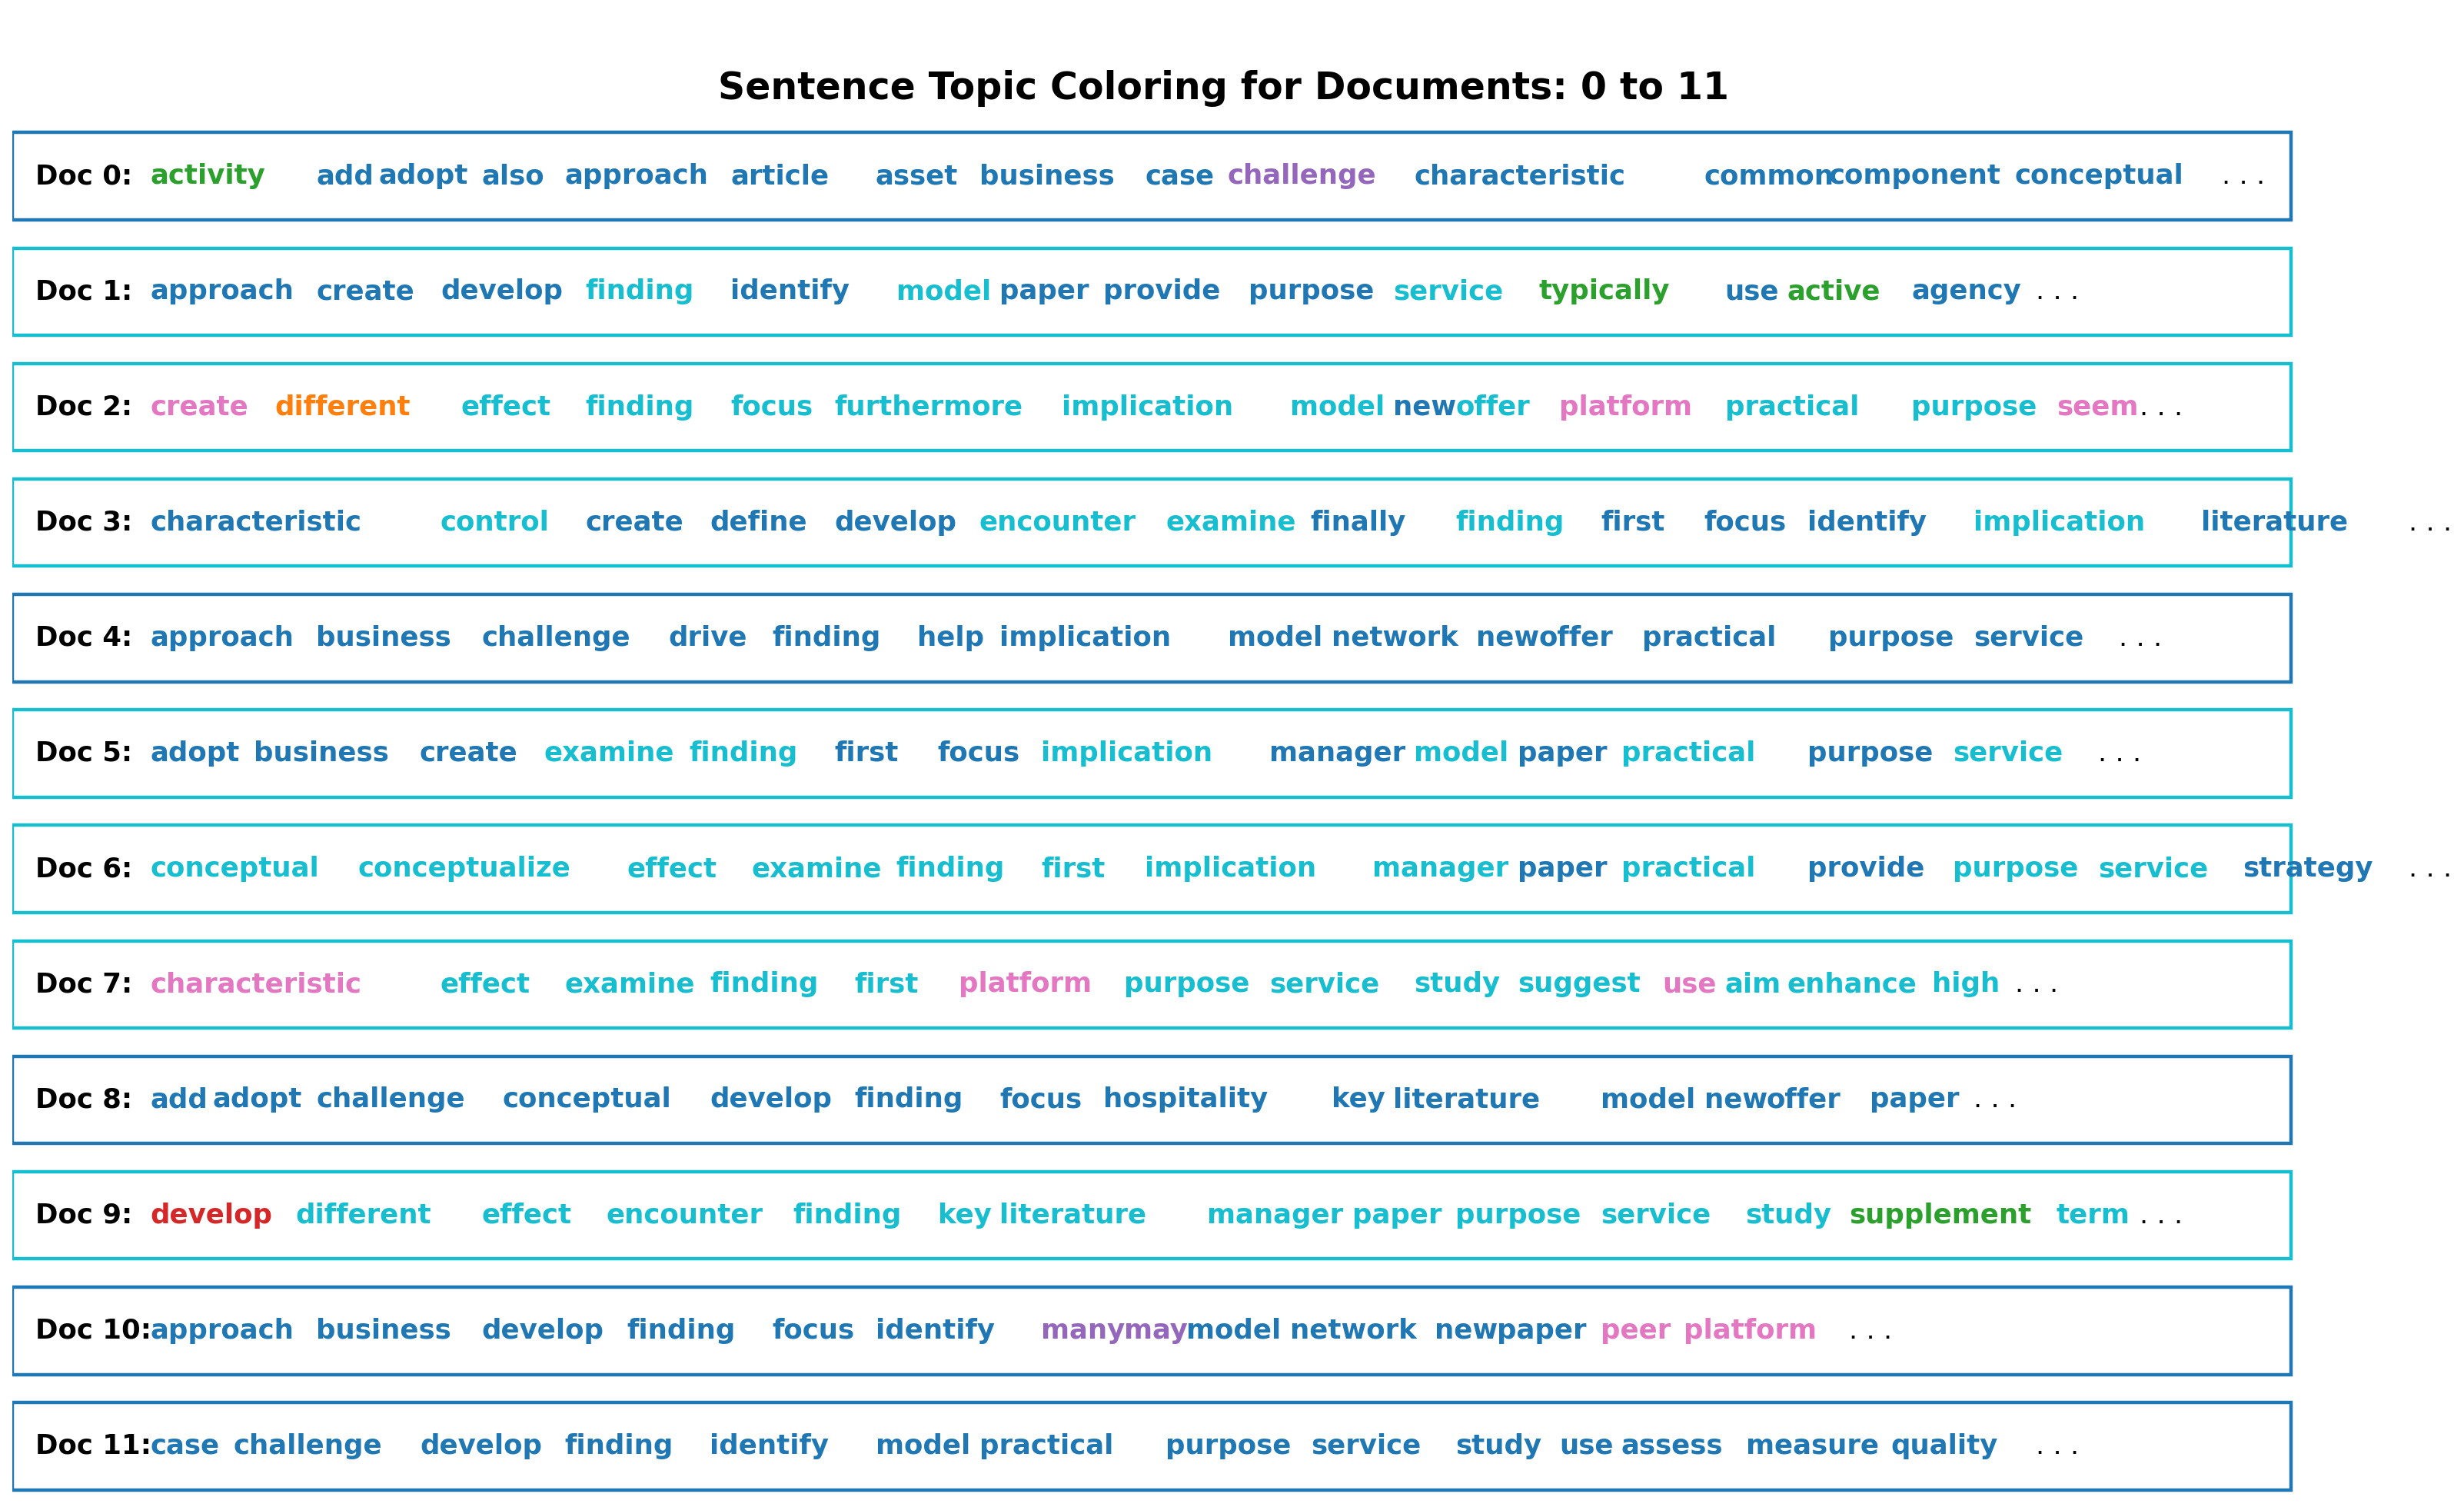

In [ ]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()

### What are the most discussed topics in the documents?
Let’s compute the total number of documents attributed to each topic.

In [ ]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

Let’s make two plots:

- The number of documents for each topic by assigning the document to the topic that has the most weight in that document.
- The number of documents for each topic by by summing up the actual weight contribution of each topic to respective documents.

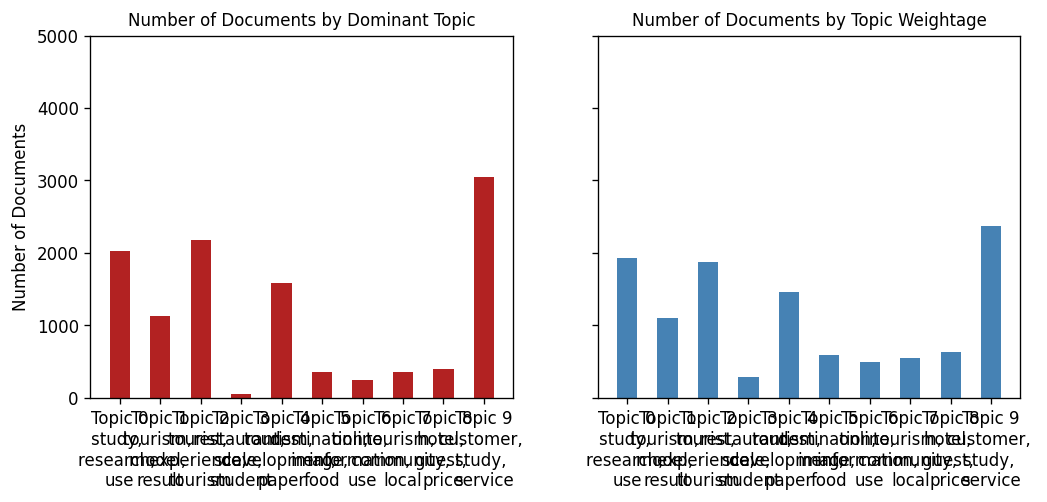

In [ ]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 5000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

### t-SNE Clustering Chart
Let’s visualize the clusters of documents in a 2D space using t-SNE (t-distributed stochastic neighbor embedding) algorithm.

In [ ]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 10
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 9109 samples in 0.014s...
[t-SNE] Computed neighbors for 9109 samples in 0.510s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9109
[t-SNE] Computed conditional probabilities for sample 2000 / 9109
[t-SNE] Computed conditional probabilities for sample 3000 / 9109
[t-SNE] Computed conditional probabilities for sample 4000 / 9109
[t-SNE] Computed conditional probabilities for sample 5000 / 9109
[t-SNE] Computed conditional probabilities for sample 6000 / 9109
[t-SNE] Computed conditional probabilities for sample 7000 / 9109
[t-SNE] Computed conditional probabilities for sample 8000 / 9109
[t-SNE] Computed conditional probabilities for sample 9000 / 9109
[t-SNE] Computed conditional probabilities for sample 9109 / 9109
[t-SNE] Mean sigma: 0.048812
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.272324
[t-SNE] KL divergence after 1000 iterations: 1.378444


### pyLDAVis
Finally, pyLDAVis is the most commonly used and a nice way to visualise the information contained in a topic model. Below is the implementation for LdaModel.

In [ ]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9     -0.019088  0.067283       1        1  21.720531
0     -0.060992 -0.062987       2        1  18.208778
2     -0.123891 -0.016708       3        1  15.512577
4     -0.181302 -0.137189       4        1  12.898453
1     -0.022666  0.159871       5        1   9.120631
8      0.143417  0.175410       6        1   5.656124
5      0.009942  0.147624       7        1   4.955998
7     -0.114674 -0.057750       8        1   4.805955
6      0.081208 -0.097897       9        1   4.405255
3      0.288046 -0.177656      10        1   2.715693, topic_info=             Term          Freq         Total Category  logprob  loglift
377         hotel   8043.000000   8043.000000  Default  30.0000  30.0000
1112  destination   5536.000000   5536.000000  Default  29.0000  29.0000
1101      tourism  14999.000000  14999.000000  Default  28.0000  28.0000
3647      tourist   7068.000000   7068.000000  Default  27.0000  27.0000
99       customer   6161.000000   6161.000000  Default  26.0000  26.0000
...           ...           ...           ...      ...      ...      ...
107        factor    180.403305   3192.960938  Topic10  -4.9708   0.7326
85            use    223.072464   8863.358398  Topic10  -4.7585  -0.0761
75          study    228.963348  15893.773438  Topic10  -4.7324  -0.6340
894       product    142.753967   1409.803467  Topic10  -5.2049   1.3160
135       quality    126.079643   2559.049805  Topic10  -5.3291   0.5956

[699 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
1755      4  0.065181  accommodation
1755      5  0.009539  accommodation
1755      6  0.925252  accommodation
0         1  0.042086       activity
0         2  0.173999       activity
...     ...       ...            ...
615       4  0.170834           year
615       5  0.488411           year
615       6  0.042709           year
615       9  0.007666           year
2713      5  0.993642           zone

[1626 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 1, 3, 5, 2, 9, 6, 8, 7, 4])

Source: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/